In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,3,12,16,480,91,799,800] #C2
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
       '127_20220705', '130_20220707', '152_20201224',"3_20220426", "12_20220502","16_20220419","480_20221205", '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']

analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)

NameError: name 'time_hypha_info' is not defined

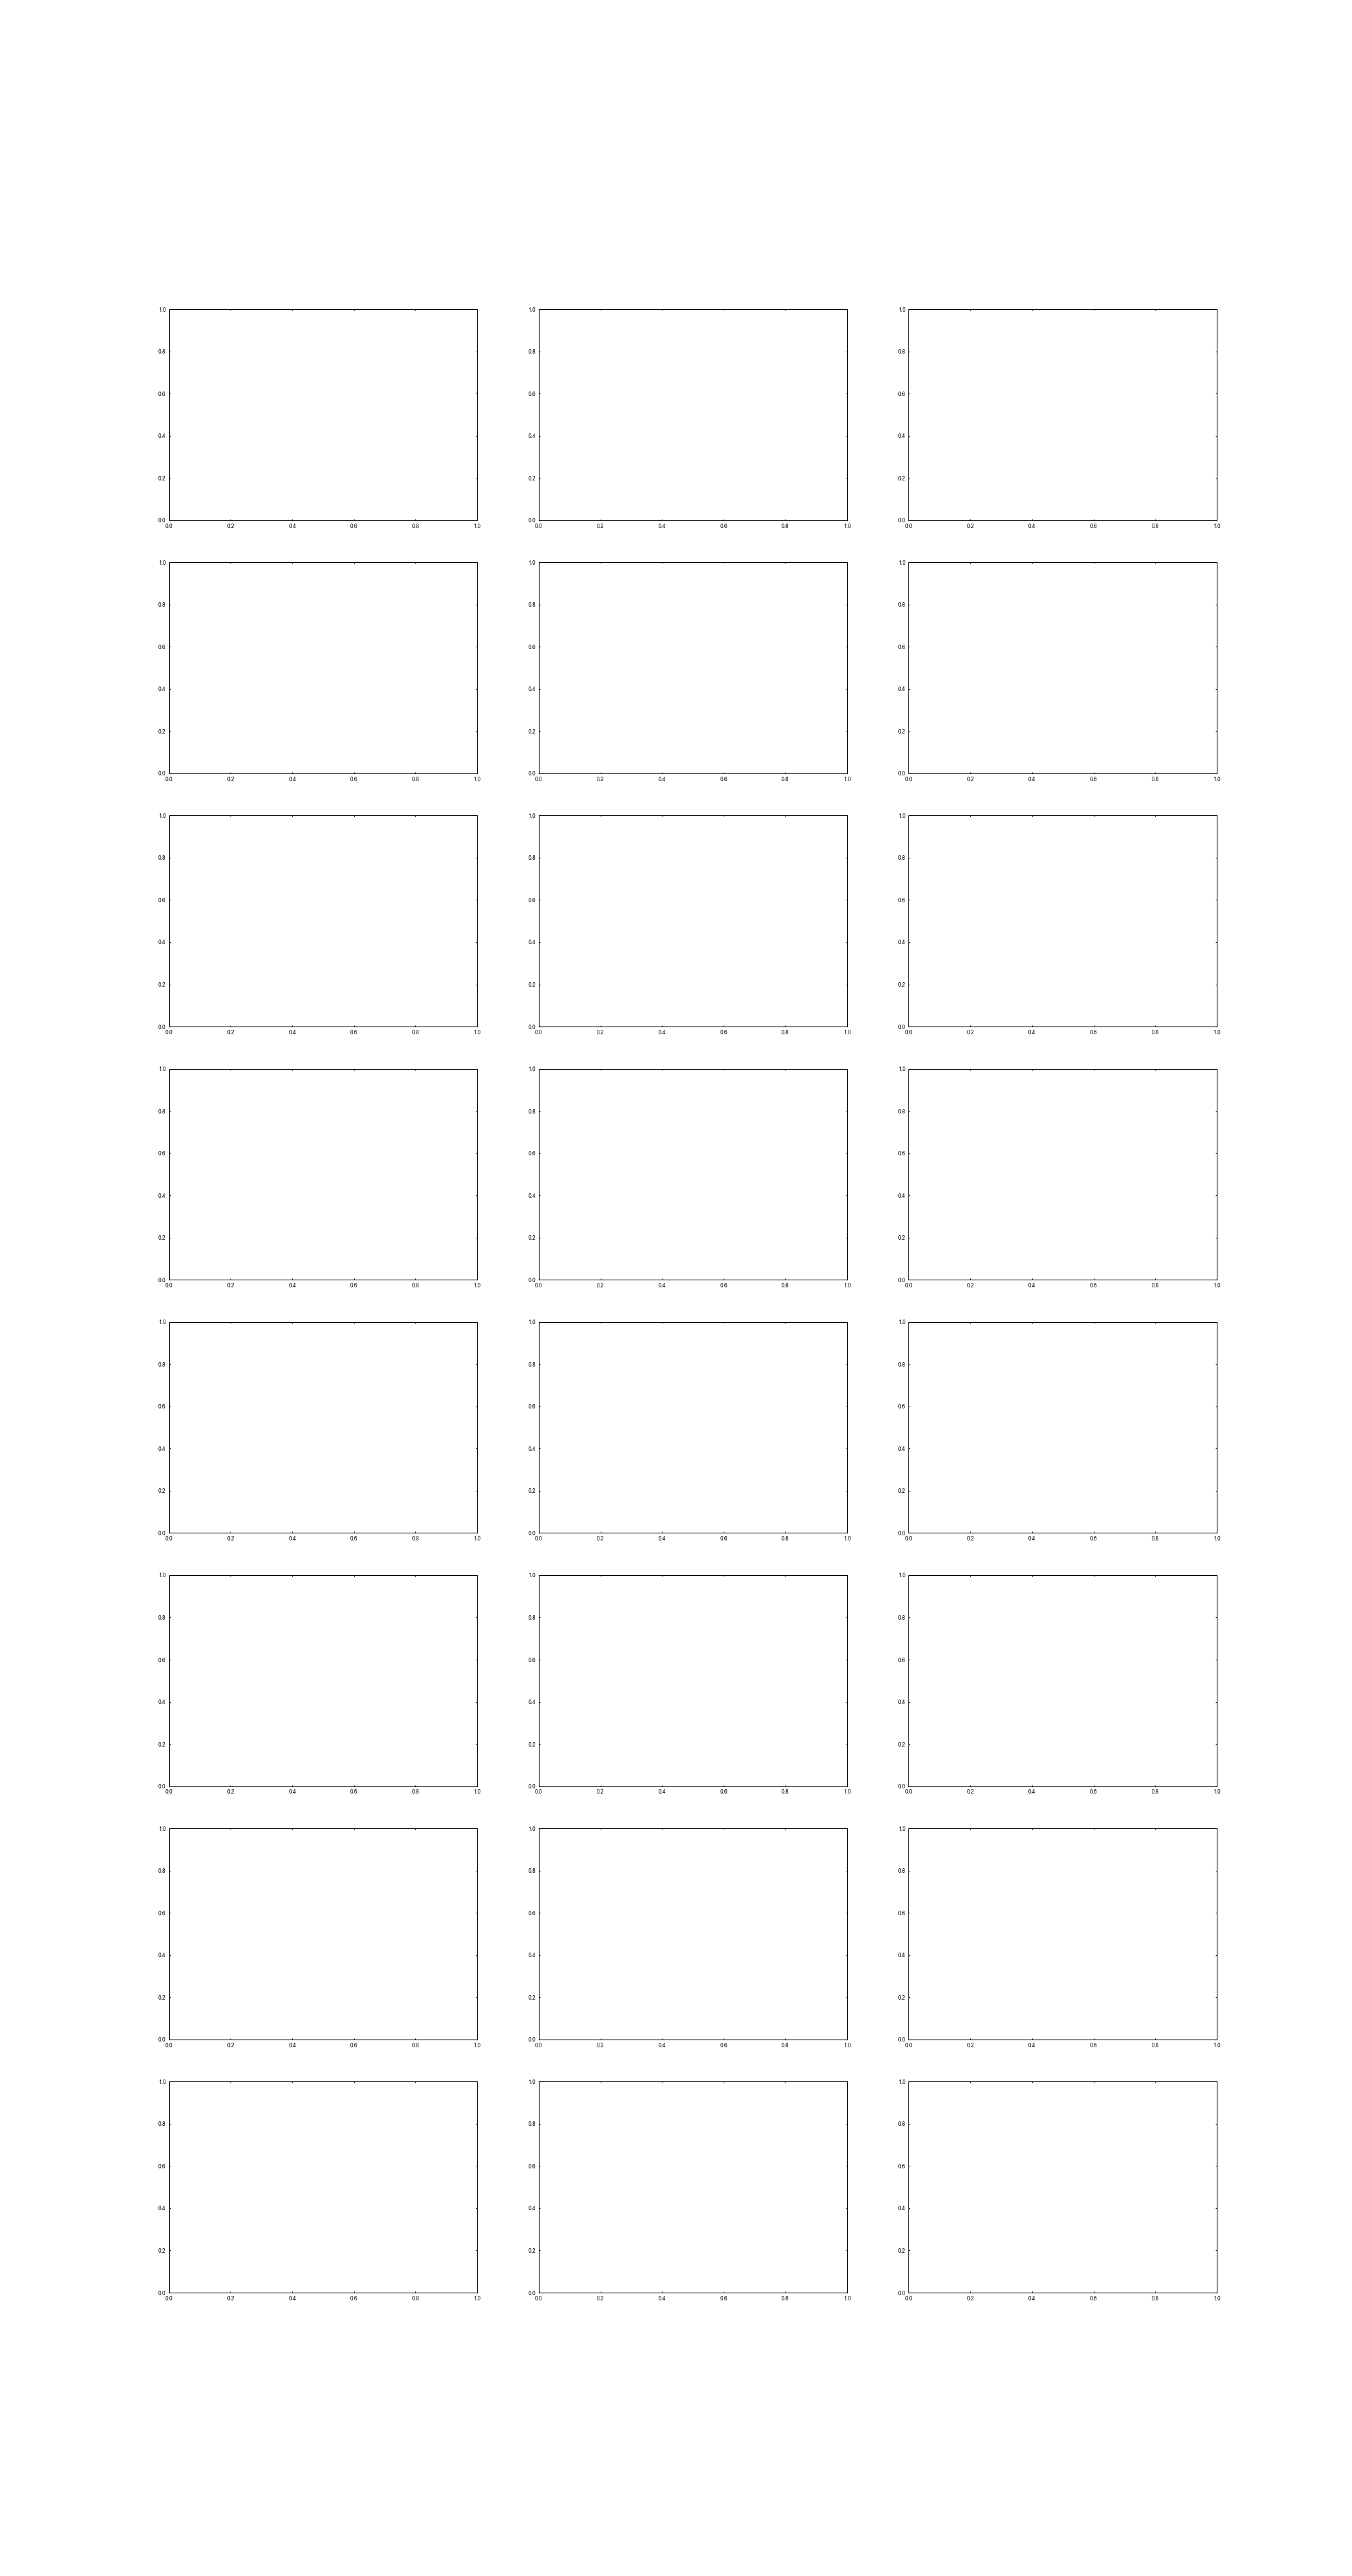

In [3]:
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)
ax_list = list(axs)
min_time = {plate_id : 0 for plate_id in plates}
max_time = {plate_id : 100 for plate_id in plates}
min_time['799_20211001'] = 100
max_time['799_20211001'] = 200
hull_speeds_dic = {}
hull_time_dic = {}
datas = {}
dys = {}
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id']==int(plate_id)]
    data,dy,select_movements = get_average_time_data(int(plate_id),time_hypha_plate,2)
    hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
            select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
            select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
            select = select.loc[select['speed'].between(150,350)]
            if len(select)>0:
                time = select['time_since_begin_h'].iloc[0]
                if time/pd.Timedelta(hours = 1)<=max_time[plate_id] and time/pd.Timedelta(hours = 1)>=min_time[plate_id]:
                    ax.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

                select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
                # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        # ax.plot(data.index/pd.Timedelta(hours = 1),data)
        ax.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
        ax.set_xlim(0,150)
        ax.set_ylim(100,350)

        ax.legend()
        # ax.set_title(f'{plate}')
        ax.set_xlabel('time since begin (h)')
        ax.set_ylabel('speed ($\mu m.h^{-1}$)')
            # break
        ax.set_xlim(0,100)
        plt.tight_layout()
        if len(hull_speeds)>0:
            ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                    color="black",
                    label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
            ax.legend()
    datas[plate] = data
    dys[plate] = dy
    hull_speeds_dic[plate] = hull_speeds
    hull_time_dic[plate] = hull_time
    ax.patch.set_facecolor(get_color(plate,folders))
    ax.patch.set_alpha(0.1)
    ax.set_title(plate)
    plt.tight_layout()

    # break
# plt.savefig(f'Figure/FigureS2C.svg')    

In [4]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
rsquared = {}

timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}

In [5]:
time_plate_info["density"] = time_plate_info["tot_length_study"]/time_plate_info["area_sep_comp"]
Ds={}
for plate in plates:
    select = time_plate_info.loc[time_plate_info["unique_id"] == int(plate)]
    Ds[plate] = select["density"].iloc[timestep[int(plate.split('_')[0])]]

C:\Users\coren\AppData\Local\Temp\ipykernel_23380\283942226.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info["density"] = time_plate_info["tot_length_study"]/time_plate_info["area_sep_comp"]


In [ ]:
len(list(Ds.values()))

In [6]:
data = [29.448598861694336,
 33.77727508544922,
 232.8802947998047,
 31.537221908569336,
 12.936720848083496,
 12.868404388427734,
 11.403223991394043,
 40.07711410522461,
 43.12382888793945,
 49.837528228759766,
 32.38702392578125,
 31.267343521118164,
 32.405029296875,
 17.28557586669922,
 12.938458442687988,
 13.938224792480469,
 8.173038482666016,
 8.688986778259277,
 8.704690933227539,
 10.036430358886719,
 11.11474323272705,
 10.832844734191895,
 42.571205139160156,
 38.00281524658203,
 41.57780456542969]

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
labels =["dens_AMF"] * len(list(Ds.values()))+["dens_free"] * len(data)
values = [D for D in Ds.values()]+[D*1000 for D in data]
df = pd.DataFrame({"density":values,"AMF_free" : labels},columns = ["density","AMF_free"])
# fig, ax = plt.subplots()
# Create the boxplot


2024-02-08 13:18:33,418-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


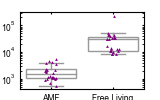

In [8]:
plt.style.use('presentation.mplstyle')

width = 1.6
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='AMF_free', y = "density",data=df, ax=ax, color='white', fliersize=0)
# Add the individual points
sns.stripplot(x='AMF_free', y = "density", data=df, ax=ax, color='purple', marker='^',size = 2)
ax.set_yscale("log")
ax.set_ylabel("hyphal density \n ($\mu m/mm^{2}$)")
ax.set_xticklabels(['AMF', 'Free Living'])

# Remove x-label
ax.set_xlabel('')
plt.savefig(os.path.join(path_figure,'FigureS4B.pdf'), transparent=True, bbox_inches='tight')

In [19]:
path_figure

'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'

In [9]:
data_myr = pd.read_csv('myristate.csv')
data_myr = data_myr[data_myr["medium"]=="'0.5Myr'"]


In [10]:
data_control = pd.read_csv('control.csv')
data_control = data_control[data_control["density"]<=10000]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
labels =["dens_AMF"] * len(list(Ds.values()))+["dens_free"] * len(data)+['Myr'] * len(data_myr)
labels += ['control']*len(data_control)
values = [D for D in Ds.values()]+[D*1000 for D in data]+data_myr['density'].to_list()
values += data_control['density'].to_list()
df = pd.DataFrame({"density":values,"AMF_free" : labels},columns = ["density","AMF_free"])
# fig, ax = plt.subplots()
# Create the boxplot


2024-02-08 16:26:09,462-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


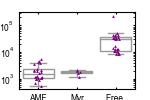

In [15]:
df = df[df['AMF_free']!='control']
width = 1.5
height = 1
fig,ax = plt.subplots(figsize=(width,height))
category_order = ['dens_AMF', 'Myr', 'dens_free']
sns.boxplot(x='AMF_free', y = "density",data=df, ax=ax, color='white', fliersize=0, order=category_order)
# Add the individual points
sns.stripplot(x='AMF_free', y = "density", data=df, ax=ax, color='purple', marker='^',size = 2, order=category_order)
ax.set_yscale("log")
ax.set_ylabel("hyphal density \n ($\mu m/mm^{2}$)")
ax.set_xticklabels(['AMF','Myr', 'Free \n Living'])

# Remove x-label
ax.set_xlabel('')
plt.savefig(os.path.join(path_figure,'FigureS4Brebutal.pdf'), transparent=True, bbox_inches='tight')

2024-02-08 13:18:38,881-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


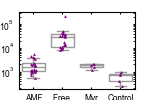

In [12]:
width = 1.5
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='AMF_free', y = "density",data=df, ax=ax, color='white', fliersize=0)
# Add the individual points
sns.stripplot(x='AMF_free', y = "density", data=df, ax=ax, color='purple', marker='^',size = 2)
ax.set_yscale("log")
ax.set_ylabel("hyphal density \n ($\mu m/mm^{2}$)")
ax.set_xticklabels(['AMF', 'Free \n Living','Myr','Control'])

# Remove x-label
ax.set_xlabel('')
plt.savefig(os.path.join(path_figure,'FigureS4Brebutal.pdf'), transparent=True, bbox_inches='tight')

In [11]:
folders.loc[folders['medium'] =="'001P100N200C-T'"]

,index,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime,Temp


In [29]:
treatments = colors.keys()

values_density = {strain : [] for strain in folders['strain'].unique()}
values_density_treatment = {strain : [] for strain in treatments}
for plate_id in plates:
    plate  = int(plate_id.split('_')[0])
    D = Ds[plate_id]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    values_density[strain].append(D)
    values_density_treatment[treatment].append(D)

for plate_id in plates:
    plate  = int(plate_id.split('_')[0])
    D = Ds[plate_id]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    if medium in ["'001P100N200C-T'","'001P100N200C'"]:
        print(plate_id)
    treatment = strain+medium

values_density_treatment["'A5''001P100N100C'"] += values_density_treatment["'A5''001P100N'"]+values_density_treatment["'A5sp3''001P100N100C'"]
values_density_treatment["'A5''001P100N200C'"] += values_density_treatment["'A5''001P100N200C-T'"]
values_density_treatment["'Agg''001P100N100C'"] += values_density_treatment["'Agg''001P100N200C'"]
strains = list(values_density.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
treatments_real=["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]

1023_20220502
1045_20220504
1053_20220413
1076_20220511
938_20220325


In [30]:
values_density_treatment_clean = {}
treatments_select=["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'"]
for treatment in treatments_select:
    values_density_treatment_clean[treatment]=values_density_treatment[treatment]

2024-01-31 10:53:00,124-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


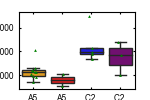

In [36]:
df = pd.DataFrame.from_dict(values_density_treatment_clean, orient='index').transpose()

# Melt the DataFrame for plotting
df_melted = df.melt(var_name='Category', value_name='Value').dropna()
width = 1.5
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='Category', y = "Value",data=df_melted, ax=ax, color='white', fliersize=0,palette = colors)
# Add the individual points
sns.stripplot(x='Category', y = "Value", data=df_melted, ax=ax, color='green', marker='^',size = 2)
# ax.set_yscale("log")
ax.set_ylabel("hyphal density \n ($\mu m/mm^{2}$)")
ax.set_xticklabels(['A5 \n 100C', 'A5 \n 200C','C2 \n 100C', 'C2 \n 200C'])

# Remove x-label
ax.set_xlabel('')
plt.savefig(os.path.join(path_figure,'FigureS4C.pdf'), transparent=True, bbox_inches='tight')

In [ ]:
labels = values_density_treatment.values
values = [D for D in Ds.values()]+[D*1000 for D in data]
df = pd.DataFrame({"density":values,"AMF_free" : labels},columns = ["density","AMF_free"])

In [ ]:
import pandas as pd
data = pd.read_csv("hannah_data.csv")
data["density"] = data["tot_length"]/data["area_sep_comp"]

In [ ]:
data['medium'].unique()

In [ ]:
# fig,ax = plt.subplots(figsize=(width,height))
fig,ax = plt.subplots()

select1 = data.loc[data["medium"]=="'1Myr'"]
select2 = data.loc[data["medium"]=="'0.5Myr'"]

data_plot = [select1["density"],select2["density"],values_density["'C2'"]]
# ax.boxplot(select["density"],positions=0)
ax.boxplot(data_plot,labels=['Myristate 100%','Myristate 50%','symbiotic'])
ax.set_ylim(0,4000)
ax.set_ylabel('density ($\mu m .mm^{-2}$)')

In [ ]:
hull_speed_dic_2 = {3: [187.5272095738,
  175.8880961916,
  181.0341688969,
  186.93168098243333,
  191.20227389895,
  200.151785636225,
  197.03390571885,
  183.8596080696333,
  220.0785906361,
  193.5472222209,
  203.90255775383332,
  216.15471250925,
  201.71558800575002,
  203.78559251068,
  187.74800241684,
  191.3043379626,
  190.99610155506664,
  200.220691956475,
  201.7919715434,
  196.48124808875,
  199.59267017509998,
  194.38776232415998,
  201.4108019739,
  220.7887397636,
  199.52873507308,
  219.80392558901667,
  204.9772465131286,
  200.75727733894288,
  184.0716493695286,
  200.01963397248,
  218.76978298031432,
  189.3932908502833,
  204.2273679813167,
  188.81763924319998,
  189.30456274916665,
  187.92222574483998,
  186.08405482630002,
  180.54020222479,
  178.19950072155999,
  176.84910749079998,
  165.7283943066,
  172.98658784319093,
  176.44311387806667,
  190.4048545989125,
  175.7023517568143,
  190.46532827753748,
  181.25242388838333,
  183.53538413808002,
  184.53853569693334,
  193.22252831292855,
  188.49064407336664,
  185.46116467068336,
  187.6166071737167,
  182.3470483986167,
  204.30941706255717,
  193.81934117998333,
  188.59148689813333,
  195.02211043721664,
  179.88368141398,
  194.07421399112854,
  182.14362677243997,
  170.9908806483714,
  191.45287470920002,
  183.37757507208576,
  171.9545156620167,
  192.4543028770857,
  184.49500615604285,
  191.46725077211667,
  192.36904019417145,
  193.62682133153336,
  175.53802982145717,
  188.0863949616286,
  180.12141667857142,
  187.28172324741428,
  181.60144766208572,
  185.43814573725,
  189.527605742925,
  178.4818561070667,
  195.53408071565,
  174.85956289874,
  197.40510907336,
  182.83915195499998,
  173.420118290625,
  191.54000324235],
 12: [198.6853476312,
  160.4918799908,
  174.1542885161,
  160.65849745415,
  230.5720566053,
  171.9497242666,
  167.7386797884,
  167.11751438625,
  152.5396537334,
  158.6911151325,
  178.7427778047,
  257.6106142144,
  169.3189831924,
  196.36391566355002,
  163.731916355975,
  157.0894702901,
  157.99242702225,
  213.97606983433332,
  178.71638159876,
  192.4547479352333,
  191.81526565175,
  184.0321298596,
  172.39138541813335,
  182.5217769237286,
  163.05902132816666,
  174.963728515775,
  169.7159254829,
  175.32195440056668,
  174.93056348754445,
  176.23047879406667,
  196.43829651278335,
  181.96753166567498,
  178.805291547,
  182.091890780725,
  178.231673748575,
  195.6945776387,
  174.59983601188333,
  187.42470198303332,
  176.02449642708575,
  183.0742753422,
  183.31289537034,
  200.43547710798336,
  176.1169568588,
  166.341069235475,
  189.04098852826002,
  173.88569296413334,
  177.845237570925,
  177.63877908665,
  183.310768098025],
 16: [159.73416544429998,
  151.538686697,
  179.11980348950001,
  170.6687144131,
  229.61468212776666,
  225.19739735369998,
  171.40774601729996,
  155.5628689247,
  180.13230107335002,
  181.681121595225,
  194.16335058355557,
  174.1093442442625,
  185.61224055929,
  184.36525121699998,
  203.76331744441816,
  201.60902379528574,
  211.84873784038334,
  207.21653768051996,
  188.1001049662,
  174.20930442436665,
  192.0674656263333,
  184.27451957032,
  175.6356039868],
 480: [173.5635809232,
  150.9540085865,
  159.3134780539,
  164.93972400835,
  162.706523909775,
  166.7205763489,
  169.36771242803331,
  169.4350713417,
  161.9002636264,
  150.4028416606,
  204.3622295959,
  200.4853894885,
  161.1692426558,
  162.4668112327,
  159.8452088992,
  195.1746129664,
  182.89130188365,
  182.0221317085,
  174.624005082725,
  187.5707324278,
  194.81999181077998,
  168.37949980406665,
  170.07054372285,
  160.53046425005,
  157.3225213852,
  175.0363525159,
  175.9225109444,
  167.797724921775,
  183.19135980663336,
  197.9668762364,
  169.89112491039998,
  178.573744361,
  160.8826975936]}

In [ ]:
for plate in hull_speed_dic_2.keys():
    hull_speeds_dic[plate] = hull_speed_dic_2[plate] 

In [ ]:
width = 1.6
height = 1
fig,ax = plt.subplots(figsize=(width,height))
# plates.remove(102)
# plates.remove(76)


    # ax.errorbar(np.mean(Cs),np.mean(hull_speed),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('wave speed ($\mu m .h^{-1}$)'  ) 
treatments = colors.keys()
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
values_speed_treatment = {strain : [] for strain in treatments}
values_density_treatment = {strain : [] for strain in treatments}
for plate_id in plates:
    plate  = int(plate_id.split('_')[0])
    D = Ds[plate_id]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(D)
    values_speed_treatment[treatment].append(np.mean(hull_speed))
    values_density_treatment[treatment].append(D)

for plate_id in plates:
    plate  = int(plate_id.split('_')[0])
    D = Ds[plate_id]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(D,np.mean(hull_speed),color=colors[treatment],alpha=0.2,marker ='x') 

values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
# for strain in strains:
#     print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
#     ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
xs = [np.nanmean(values_density[strain]) for strain in strains]
ys = [np.nanmean(values_speed[strain]) for strain in strains]
stdxs = [2*np.nanstd(values_density[strain])/np.sqrt(len(values_density[strain])) for strain in strains]
stdys = [2*np.nanstd(values_speed[strain])/np.sqrt(len(values_density[strain])) for strain in strains]

ellipses = [Ellipse((x,ys[j]), stdxs[j], stdys[j], facecolor=colors_strain[strains[j]], edgecolor="white") for j,x in enumerate(xs)]

for ellipse in ellipses:
    ax.add_artist(ellipse)
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Supplementary material\FigureS4"

# plt.savefig(os.path.join(path_figure,'FigureS4A.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
width = 1.6
height = 1
fig,ax = plt.subplots(figsize=(width,height))
# plates.remove(102)
# plates.remove(76)


    # ax.errorbar(np.mean(Cs),np.mean(hull_speed),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_ylabel('saturation density \n ($\mu m$ $mm^{-2}$)')
ax.set_xlabel('wave speed ($\mu m$ $h^{-1}$)'  ) 
treatments = colors.keys()
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
values_speed_treatment = {strain : [] for strain in treatments}
values_density_treatment = {strain : [] for strain in treatments}
for plate_id in plates:
    plate  = int(plate_id.split('_')[0])
    D = Ds[plate_id]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(D)
    values_speed_treatment[treatment].append(np.mean(hull_speed))
    values_density_treatment[treatment].append(D)

for plate_id in plates:
    plate  = int(plate_id.split('_')[0])
    D = Ds[plate_id]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(hull_speed),D,color=colors[treatment],alpha=0.2,marker ='x') 

values_density_treatment["'A5''001P100N100C'"] += values_density_treatment["'A5''001P100N'"]+values_density_treatment["'A5sp3''001P100N100C'"]
values_speed_treatment["'A5''001P100N100C'"] += values_speed_treatment["'A5''001P100N'"]+values_speed_treatment["'A5sp3''001P100N100C'"]
values_speed_treatment["'Agg''001P100N100C'"] += values_speed_treatment["'Agg''001P100N200C'"]
values_density_treatment["'Agg''001P100N100C'"] += values_density_treatment["'Agg''001P100N200C'"]

strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
treatments_real=["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]
# length_production
# for strain in strains:
#     print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
#     ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
xs = [np.nanmean(values_density_treatment[treatment]) for treatment in treatments_real]
ys = [np.nanmean(values_speed_treatment[treatment]) for treatment in treatments_real]
stdxs = [2*np.nanstd(values_density_treatment[treatment])/np.sqrt(len(values_density_treatment[treatment])) for treatment in treatments_real]
stdys = [2*np.nanstd(values_speed_treatment[treatment])/np.sqrt(len(values_speed_treatment[treatment])) for treatment in treatments_real]
counts = [(treatment,len(values_density_treatment[treatment])) for treatment in treatments_real]

for j,treatment in enumerate(treatments_real):
    ax.scatter(ys[j],xs[j],color=colors[treatment])
    ax.errorbar(ys[j],xs[j], xerr=stdys[j], yerr=stdxs[j], color=colors[treatment],alpha = 0.7)
# ellipses = [Ellipse((x,ys[j]), stdxs[j], stdys[j], facecolor=colors[treatments_real[j]], edgecolor="white") for j,x in enumerate(xs)]

# for ellipse in ellipses:
#     ax.add_artist(ellipse)
ax.set_yscale('log')
ax.set_ylim(600,10000)
plt.savefig(os.path.join(path_figure,'FigureS4A.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
counts

In [ ]:
import itertools
flattened_list = list(itertools.chain.from_iterable(values_density_treatment.values()))

In [ ]:
r = 2.5
dry_ratio = 0.1
densities = np.array(flattened_list)*np.pi*r**2*dry_ratio/10*1e-3 #densities in ug.cm**2

In [ ]:
datatable = pd.read_csv('Fungal_trait_data.csv')
fig,ax = plt.subplots()
ax.boxplot([datatable['density'],densities])

In [ ]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

In [ ]:
plate

In [ ]:
time_plate_info['time_since_begin'] = time_plate_info['time_since_begin']/pd.Timedelta(hours=1)

In [ ]:

# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)

maxis = {plate :12 for plate in plate_select}
maxis[94] = 13
maxis[152] = 11
maxis2 = {plate :12 for plate in plate_select}
maxis2[52] = 6
maxis2[938] = 7
# maxis[938] = 8

bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s
    axins2 = inset_axes(ax, width="30%", height="40%", loc=1)
    if len(ds)>0:
        x0 = np.linspace(np.min(ds),np.max(ds),10)
        statistic = make_stat(x0,axins2)

        data = np.array((ds,Cs))
#         n_resamples=1000
#         std = scipy.stats.bootstrap(data,statistic,
#                                     vectorized = False,
#                                     method="basic",
#                                     n_resamples = n_resamples,
#                                     paired= True).standard_error
#         X = sm.add_constant(ds, prepend=False)
#         model = sm.OLS(Cs,X)
#         res = model.fit()
#         a,b = res.params[0],res.params[1]
#         axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
#         axins2.scatter(ds,Cs,s = 2)
#         axins2.set_ylim(0,4000)
        ax.set_ylim(0,4000)

#         axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
#         axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
#         axins2.tick_params(labelsize = 5)
#         axins2.legend(fontsize = 6)
        ax.patch.set_facecolor(get_color(plate,folders))
        ax.patch.set_alpha(0.1)
    # break
plt.savefig(f'Figure/FigureS2B.svg')    

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    ds = dss[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    tot_ds+=ds
    tot_Cs+=Cs
    ax.plot(ds,Cs,color=colors[treatment])
patches = []
for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
    print(treatment)
    patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
ax.legend(handles=patches)
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density ($\mu m.mm^{-1}$)')
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed),color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('wave speed ($\mu m .h^{-1}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
# for strain in strains:
#     print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
#     ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
xs = [np.nanmean(values_density[strain]) for strain in strains]
ys = [np.nanmean(values_speed[strain]) for strain in strains]
stdxs = [2*np.nanstd(values_density[strain])/np.sqrt(len(values_density[strain])) for strain in strains]
stdys = [2*np.nanstd(values_speed[strain])/np.sqrt(len(values_density[strain])) for strain in strains]

ellipses = [Ellipse((x,ys[j]), stdxs[j], stdys[j], facecolor=colors_strain[strains[j]], edgecolor="white") for j,x in enumerate(xs)]

for ellipse in ellipses:
    ax.add_artist(ellipse)
plt.tight_layout()
plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
plate_select

In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)
# plate_select.remove(30)
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed)**2*np.mean(Cs)*1e-9,color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(np.array(values_density[strain])*np.array(values_speed[strain])**2)*1e-9,label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)
# plate_select.remove(30)
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(hull_speed),np.mean(hull_speed)**2*np.mean(Cs)*1e-9,color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('expansion speed ($\mu m .h^{-1}$)'  ) 
ax.set_ylabel('growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    # print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_speed[strain]),np.nanmean(np.array(values_density[strain])*np.array(values_speed[strain])**2)*1e-9,label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
for strain in strains:
    print(strain)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain) 
    ax.errorbar(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),np.nanstd(values_speed[strain])/np.sqrt(len(values_speed[strain])))    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('hull pusher speed ($\mu m .h^{-1}$)'  ) 
plt.legend()
plt.tight_layout()
plt.savefig(f'Figure/Figure2B.svg')    

In [ ]:
plate_2022 = [plate for plate in plate_2022 if plate!=30]
plate_2022

In [ ]:
column = "ring_biovolume_density_incr-100_index-0"
plate_select = time_plate_info.loc[~time_plate_info[column].isnull()]['Plate'].unique().tolist()
folders['CrossDate'] = folders['CrossDate'].astype(str).str.replace("'","").astype(int)
plate_2022 = folders.loc[folders['CrossDate']>20220101]['Plate'].unique()
plate_2022 = [plate for plate in plate_2022 if plate!=30]

plates = [plate for plate in plates if int(plate.split('_')[0]) in plate_select]
plates = [plate for plate in plates if int(plate.split('_')[0]) in plate_2022]
plate_select = [int(plate.split('_')[0])  for plate in plates]

In [ ]:

# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)
meancurves3 = {}
meancurves4 = {}
Css2 = {}
lambss2 = {}
dss2 = {}
t0ss2 = {}
maxis = {plate :12 for plate in plate_select}
maxis[94] = 13
maxis[152] = 11
maxis2 = {plate :12 for plate in plate_select}
maxis2[52] = 6
maxis2[938] = 7
# maxis[938] = 8

bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate_biovolume(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
    meancurves3[plate]=meancurve
    meancurves4[plate]=meancurve2
    Css2[plate] = Cs
    lambss2[plate] = lambs
    dss2[plate] = ds
    t0ss2[plate] = t0s
    axins2 = inset_axes(ax, width="30%", height="40%", loc=1)
    if len(ds)>0:
        x0 = np.linspace(np.min(ds),np.max(ds),10)
        statistic = make_stat(x0,axins2)

        data = np.array((ds,Cs))
#         n_resamples=1000
#         std = scipy.stats.bootstrap(data,statistic,
#                                     vectorized = False,
#                                     method="basic",
#                                     n_resamples = n_resamples,
#                                     paired= True).standard_error
#         X = sm.add_constant(ds, prepend=False)
#         model = sm.OLS(Cs,X)
#         res = model.fit()
#         a,b = res.params[0],res.params[1]
#         axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
#         axins2.scatter(ds,Cs,s = 2)
#         axins2.set_ylim(0,4000)
        ax.set_ylim(0,4000)

#         axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
#         axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
#         axins2.tick_params(labelsize = 5)
#         axins2.legend(fontsize = 6)
        ax.patch.set_facecolor(get_color(plate,folders))
        ax.patch.set_alpha(0.1)
    # break
# plt.savefig(f'Figure/FigureS2B.svg')    

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    ds = dss2[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    tot_ds+=ds
    tot_Cs+=Cs
    ax.plot(ds,Cs,color=colors[treatment])
patches = []
for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
    print(treatment)
    patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
ax.legend(handles=patches)
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation biovolume density ($\mu m^{3}.mm^{-1}$)')
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed),color=colors[treatment],alpha=0.2,marker ='x') 
    ax.errorbar(np.mean(Cs),np.mean(hull_speed),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('hull pusher speed ($\mu m .h^{-1}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed)**2*np.mean(Cs)*1e-9,color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('biovolume saturation density ($\mu m^{3} .mm^{-2}$)')
ax.set_ylabel('biovolume growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(np.array(values_density[strain])*np.array(values_speed[strain])**2)*1e-9,label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.sqrt(np.mean(Cs2)/np.mean(Cs)/np.pi),color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('effective mean radius ($\mu m$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_density_biovolume = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_density[strain].append(np.mean(Cs))
    values_density_biovolume[strain].append(np.mean(Cs2))
values_density["'A5'"] += values_density["'A5sp3'"]
values_density_biovolume["'A5'"] += values_density_biovolume["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    ax.scatter(np.nanmean(values_density[strain]),np.sqrt(np.nanmean(np.array(values_density_biovolume[strain])/np.array(values_density[strain]))/np.pi),s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.sqrt(np.mean(Cs2)/np.mean(Cs)/np.pi),label=plate,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_density_biovolume = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_density[strain].append(np.mean(Cs))
    values_density_biovolume[strain].append(np.mean(Cs2))
values_density["'A5'"] += values_density["'A5sp3'"]
values_density_biovolume["'A5'"] += values_density_biovolume["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    ax.scatter(np.nanmean(values_density[strain]),np.sqrt(np.nanmean(np.array(values_density_biovolume[strain])/np.array(values_density[strain]))/np.pi),s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    
ax.legend()

In [ ]:
selection = time_hypha_info.loc[time_hypha_info['Plate'].isin(plate_select)]
selection = time_hypha_info.loc[time_hypha_info['Plate'].isin([1045, 1014, 1023, 1053, 1076,   52, 1042,   84])]
# selection = time_hypha_info.loc[time_hypha_info['Plate'].isin([1045])]

# selection = time_hypha_info.loc[time_hypha_info['Plate'].isin([52,84])]
selection = selection.loc[selection['speed'].between(50,350)]
selection = selection.loc[selection['av_width'].between(0.5,12)]
selection = selection.loc[selection['width_tip_edge'].between(0.5,12)]

selection = selection.loc[selection['time_since_begin_h']/pd.Timedelta(hours=1)<=150]

In [ ]:


selection.columns

In [ ]:
plates = selection['Plate'].unique()

In [ ]:
selection.columns
selection = selection.sort_values('av_width')
selection['speed_rolling']=selection['speed'].rolling(300).mean()

In [ ]:
selection['strain'] = selection['strain'].str.replace("'A5sp3'","'A5'")

In [ ]:
plates = [1045]

In [ ]:
strains = selection['strain'].unique()

In [ ]:
column = 'av_width'
for plate in plates:
    fig, ax = plt.subplots()
    
    subs_select = selection.loc[selection['Plate']==plate].copy()
    subs_select = subs_select.sort_values(column)
    subs_select['speed_rolling']=subs_select['speed'].rolling(300).quantile(0.8)
    ax.scatter(subs_select[column],subs_select['speed'],alpha = 0.01)
    ax.plot(subs_select[column],subs_select['speed_rolling'],color="red",label='80th percentile')
    ax.set_xlabel('hypha average width ($\mu m$)')
    ax.set_ylabel('hypha growth speed ($\mu m.h^{-1}$)')
    plt.tight_layout()
    ax.legend()

In [ ]:
values_density